# Investigating the composition of academics in economics

In [1]:
import re 
import os
from time import sleep
import requests 
import pandas as pd 
import numpy as np 
from bs4 import BeautifulSoup

import pretty

import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns 

from src import (retriever,
                get_coauthors)


First i scrape the complete list of authors on Ideas.RePec. I use my `cached()` function to avoid reloading data from the webserver every time i run my script. 

In [2]:
authors = retriever.cached(retriever.get_authors, path = 'data/authors.csv')
authors = authors.dropna()

Read from file.


Next we convert the number of publications into an integer and remove authors with 0 or unknown number of publications. The people with 0 publications will not enter the following analysis anyways.

In [3]:
def asInteger(s):
    nums = re.findall(r'\d+', s)
    if len(nums)>0:
        return int(''.join(nums))
    return 0

authors['pubs'] = authors['pubs'].apply(asInteger)
authors = authors.query("pubs > 0")


To get a sense of the data i plot the density of publication counts. To ease readablity the graph has a log axis

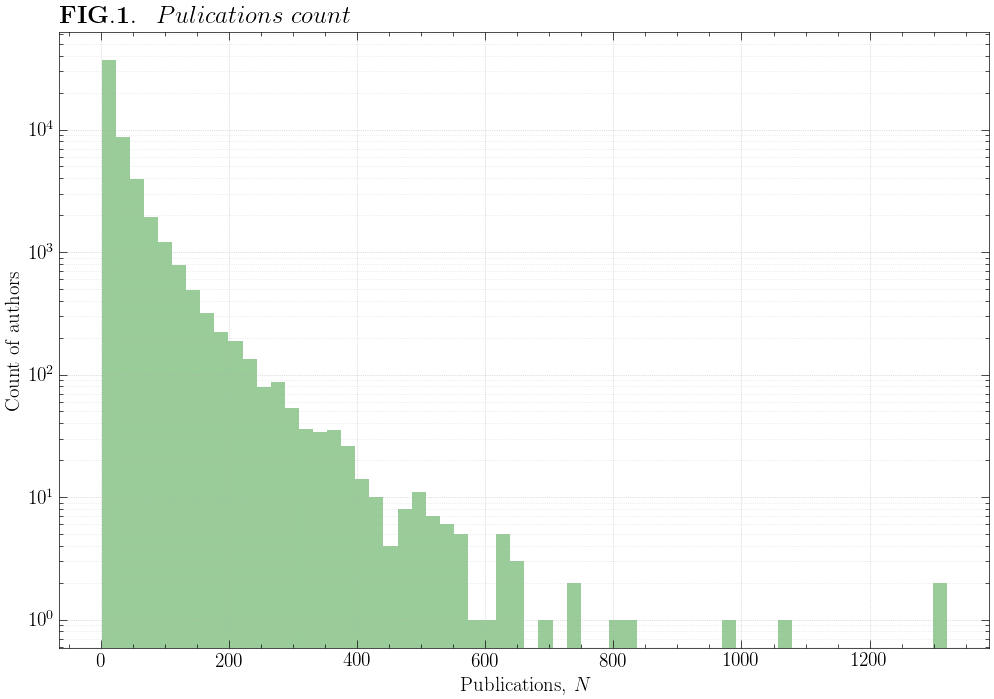

In [4]:
with pretty.Classic():
    fig = plt.figure(figsize = (12,8))    
    ax = fig.add_subplot(1, 1, 1)
    ax.hist(authors.pubs, alpha = 0.4, color = 'green', bins = 60)
    
    ax.grid(which='minor', alpha=0.4, axis='y', linestyle='dotted')
    ax.grid(which='major', alpha=0.8, linestyle='dotted')
    ax.annotate('$\mathbf{FIG.1.}$', xy=(0, 1.015), xycoords='axes fraction', ha='left',
            fontsize=18, annotation_clip=False)
    ax.annotate('$Pulications \ count$', xy=(0.105, 1.015), xycoords='axes fraction', ha='left',
            fontsize=18, annotation_clip=False)
    ax.set_xlabel("Publications, $N$")
    ax.set_ylabel("Count of authors")
    ax.set_yscale('log')
    plt.show()

From this alone we learn quite a lot. First of, it seems it is most common to have 1 publication in total, this suggests quite heavy selection into academic careers. Second, the top published in terms of $N$ have an insane number of publications. The highest $N$ is held by [Peter Nijkamp](https://en.wikipedia.org/wiki/Peter_Nijkamp).

Now we need to get information on the collaborations of each author. To do this i will scrape the individual author pages. There is quite a lot of data here, so i do it in a loop and try to store only the bare minimum of data.

In [5]:
from sklearn.utils import shuffle
authors = shuffle(authors)

# Only run if you want to scrape a lot of pages!
RUN = False

if RUN:
    for url, name in zip(authors.url, authors.name):
        sleep(5)    
        name = ''.join(re.findall('[A-Za-z]+', name))
        data = retriever.cached(retriever.get_author_work, f'data/authorsWork/{name}.csv', url)

Now i pull information from each of the scraped author pages to construct a list of coauthors to each author in my dataset.

In [6]:
authors['coauthors'] = authors.name.apply(get_coauthors)
authors['n_coauthors'] = authors.coauthors.apply(len)

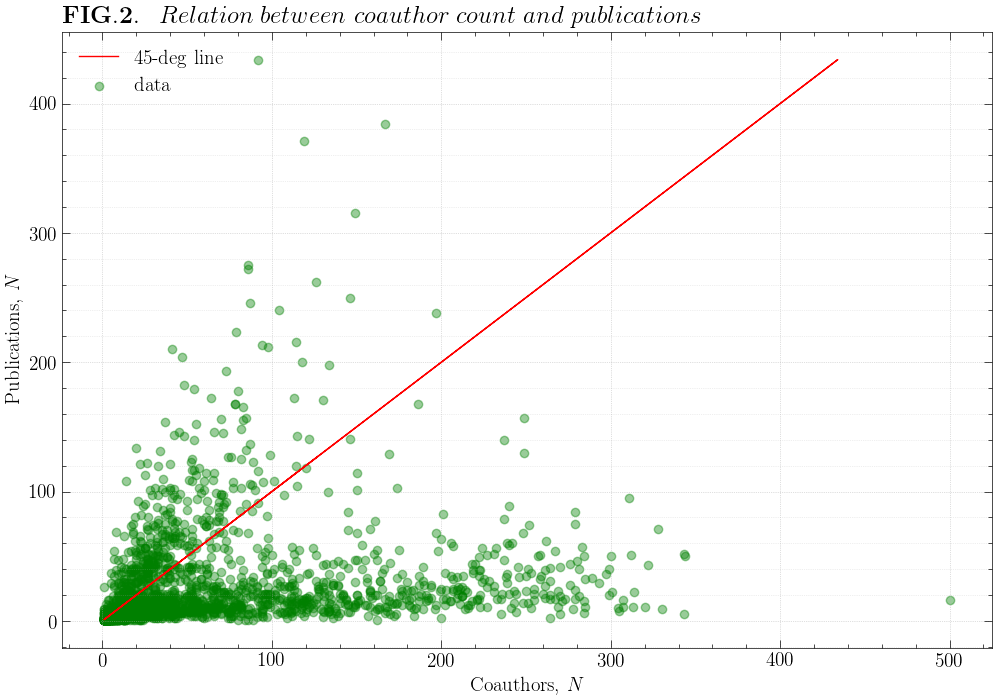

In [7]:
with pretty.Classic():
    fig = plt.figure(figsize = (12,8))    
    ax = fig.add_subplot(1, 1, 1)
    
    ax.scatter(authors.query('n_coauthors > 0').n_coauthors,
               authors.query('n_coauthors > 0').pubs,
               alpha = 0.4, color = 'green', label = 'data')
    
    ax.plot(authors.query('n_coauthors > 0').pubs, authors.query('n_coauthors > 0').pubs, color = 'red', label = '45-deg line')
    
    ax.grid(which='minor', alpha=0.4, axis='y', linestyle='dotted')
    ax.grid(which='major', alpha=0.8, linestyle='dotted')
    ax.annotate('$\mathbf{FIG.2.}$', xy=(0, 1.015), xycoords='axes fraction', ha='left',
            fontsize=18, annotation_clip=False)
    ax.annotate('$Relation \ between \ coauthor \ count \ and \ publications$', xy=(0.105, 1.015), xycoords='axes fraction', ha='left',
            fontsize=18, annotation_clip=False)
    
    ax.set_xlabel("Coauthors, $N$")
    ax.set_ylabel("Publications, $N$")
        
    ax.legend()
    
    plt.show()

As a last descriptive effort i will try to plot the average number of publications and coauthors by the first letter of ones name. The idea here is that names early in the alphabet might be more likely to appear in citations, and thus induce readers to better remember these researchers. 

In [8]:
import string
converter = {l: n for l,n in zip(string.ascii_lowercase, range(len(string.ascii_lowercase)))}

def convert(l):
    try:
        return converter[l.lower()]
    except KeyError:
        return 30
    

authors['firstLetter'] = authors.name.apply(lambda x: x[0])
authors['firstLetterIdx'] = authors.firstLetter.apply(convert)


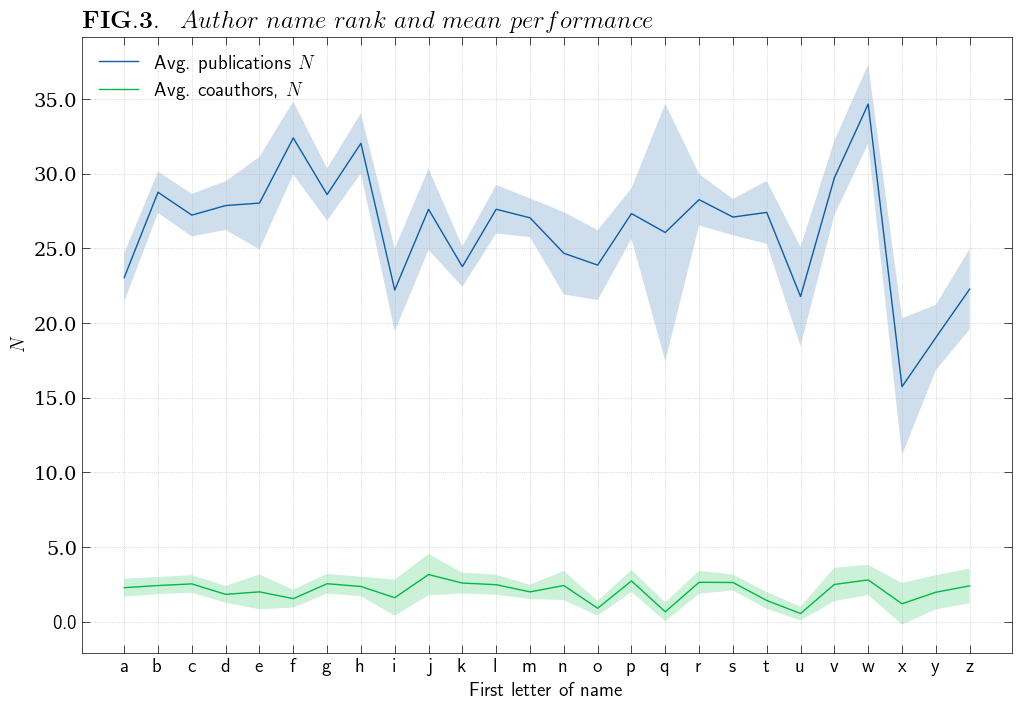

In [9]:
from matplotlib.ticker import FuncFormatter

def plotByFirstLetter(authors):
    
    def math_formatter(x, pos):
        return "{}".format(x).replace(u"\u2212", "-")
    
    df = authors.groupby('firstLetterIdx').agg(['mean', 'sem']).reset_index()
    df = df[df.firstLetterIdx < 30]

    df['pubsup'] = df.pubs['mean'] + 1.96 * df.pubs['sem']
    df['pubslo'] = df.pubs['mean'] - 1.96 * df.pubs['sem']

    df['coauthup'] = df.n_coauthors['mean'] + 1.96 * df.n_coauthors['sem']
    df['coauthlo'] = df.n_coauthors['mean'] - 1.96 * df.n_coauthors['sem']


    with pretty.styles.Classic():
        fig = plt.figure(figsize = (12,8))    
        ax = fig.add_subplot(1, 1, 1)
        ax.minorticks_off()        
        ax.yaxis.set_major_formatter(FuncFormatter(math_formatter)) 
        
        ax.plot(df.firstLetterIdx, df.pubs['mean'], label = r'Avg. publications $N$')        
        ax.fill_between(df.firstLetterIdx, df['pubsup'], df['pubslo'], alpha = .2)

        ax.plot(df.firstLetterIdx, df.n_coauthors['mean'], label = r'Avg. coauthors, $N$')
        ax.fill_between(df.firstLetterIdx, df['coauthup'], df['coauthlo'], alpha = .2)

        ax.set_xticks([i for i in df.firstLetterIdx])
        ax.set_xticklabels([i for i in string.ascii_lowercase])    

        ax.annotate('$\mathbf{FIG.3.}$', xy=(0, 1.015), xycoords='axes fraction', ha='left',
                fontsize=18, annotation_clip=False)
        ax.annotate('$Author \ name \ rank \ and \ mean \ performance$', xy=(0.105, 1.015), xycoords='axes fraction', ha='left',
                fontsize=18, annotation_clip=False)

        ax.set_xlabel("First letter of name")
        ax.set_ylabel(r"$N$")

        ax.grid(which='major', alpha=0.8, linestyle='dotted')        
        ax.legend(loc = 'upper left')

        return plt

plotByFirstLetter(authors)
plt.show()

Which doesn't seem to shoe any major differences across the board. (i do use the first letter of their name as listed on Ideas, so this should be how they are written in references. 